In [32]:
import csv
import json
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from keras.models import Model
from keras import backend as K
from keras.layers import Input, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Concatenate, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [33]:
def visualize_doc_embeddings(my_doc_embs,my_colors,my_labels,my_name):
    my_pca = PCA(n_components=10)
    my_tsne = TSNE(n_components=2,perplexity=10) #https://lvdmaaten.github.io/tsne/
    doc_embs_pca = my_pca.fit_transform(my_doc_embs) 
    doc_embs_tsne = my_tsne.fit_transform(doc_embs_pca)
    
    fig, ax = plt.subplots()
    
    for label in list(set(my_labels)):
        idxs = [idx for idx,elt in enumerate(my_labels) if elt==label]
        ax.scatter(doc_embs_tsne[idxs,0], 
                   doc_embs_tsne[idxs,1], 
                   c = my_colors[label],
                   label=str(label),
                   alpha=0.7,
                   s=40)
    
    ax.legend(scatterpoints=1)
    fig.suptitle('t-SNE visualization doc embeddings',fontsize=15)
    fig.set_size_inches(11,7)
    fig.savefig(my_name + '.pdf')


### fill the gap in the cnn_branch function below ###
### add a convolutional and a pooling layer ###
# conv layers: https://keras.io/layers/convolutional/
# pooling layers: https://keras.io/layers/pooling/
# layers can be combined by nesting them as: layer_b(parameters_b)(layer_a(parameters_a)(input))

def cnn_branch(n_filters,k_size,d_rate,my_input):
    return Dropout(d_rate)(
        GlobalMaxPooling1D()(
            Conv1D(filters = n_filters, kernel_size = k_size, activation = 'relu')(my_input)))


In [34]:
# = = = = = parameters = = = = =

mfw_idx = 2 # index of the most frequent words in the dictionary
padding_idx = 0
oov_idx = 1

d = 30 # dimensionality of word embeddings
max_size = 60 # max allowed size of a document
nb_branches = 2
nb_filters = 50
filter_sizes = [3,4]
drop_rate = 0.3 # amount of dropout regularization
batch_size = 64
nb_epochs = 6
my_optimizer = 'adam'

In [35]:
# = = = = = loading data = = = = =

# load dictionary of word indexes (sorted by decreasing frequency across the corpus)
with open('./data/word_to_index.json', 'r') as my_file:
    word_to_index = json.load(my_file)

# invert mapping (for sanity checking, later)
index_to_word = dict((v,k) for k,v in word_to_index.items())

with open('./data/training.csv', 'r') as my_file:
    reader = csv.reader(my_file, delimiter=',')
    x_train = list(reader)

with open('./data/test.csv', 'r') as my_file:
    reader = csv.reader(my_file, delimiter=',')
    x_test = list(reader)

with open('./data/training_labels.txt', 'r') as my_file:
    y_train = my_file.read().splitlines()

with open('./data/test_labels.txt', 'r') as my_file:
    y_test = my_file.read().splitlines()

# turn lists of strings into lists of integers
x_train = [[int(elt) for elt in sublist] for sublist in x_train]
x_test = [[int(elt) for elt in sublist] for sublist in x_test]  

y_train = [int(elt) for elt in y_train]
y_test = [int(elt) for elt in y_test]

print('data loaded')

# = = some sanity checking = =
    
print('index of "the":',word_to_index['the']) # most frequent word
print('index of "movie":',word_to_index['movie']) # very frequent word
print('index of "elephant":',word_to_index['elephant']) # less frequent word
    
# reconstruct first review
rev = x_train[0]
print (' '.join([index_to_word[elt] if elt in index_to_word else 'OOV' for elt in rev]))
# compare it with the original review: https://www.imdb.com/review/rw2219371/?ref_=tt_urv

# = = = = = truncation and padding = = = = =

# truncate reviews longer than 'max_size'
x_train = [rev[:max_size] for rev in x_train]
x_test = [rev[:max_size] for rev in x_test]

# pad reviews shorter than 'max_size' with the special padding token
x_train = [rev+[padding_idx]*(max_size-len(rev)) if len(rev)<max_size else rev for rev in x_train]
x_test = [rev+[padding_idx]*(max_size-len(rev)) if len(rev)<max_size else rev for rev in x_test]

# all reviews should now be of size 'max_size'
assert max_size == list(set([len(rev) for rev in x_train]))[0] and max_size == list(set([len(rev) for rev in x_test]))[0]

print('truncation and padding done')


data loaded
index of "the": 2
index of "movie": 20
index of "elephant": 4491
oh dear ! what a disappointment . i've been watching old westerns on british tv for decades , and i wasn't aware of this one until its showing yesterday - most other scott westerns come around every few years or so and are usually worth watching again.the rich colour and outdoor sets were good , but that's all i can say about this film . i have to agree with most of the other negative comments already made . several times i felt like turning it off , and finally i did , halfway through , something i hardly ever OOV seemed unusually OOV in charming the girls , his two sidekicks were annoying and so was the mexican bandit lad . and i've a feeling the army uniforms were 20 years or so too modern , not that this has bothered makers of many other OOV it got better in the second half , but i couldn't be bothered to wait and see .
truncation and padding done


In [36]:
len(index_to_word)

20756

In [41]:
# = = = = = defining architecture = = = = =

# see guide to Keras' functional API: https://keras.io/getting-started/functional-api-guide/
# core layers: https://keras.io/layers/core/

doc_ints = Input(shape=(max_size,))

### fill the gap (add an Embedding layer) https://keras.io/layers/embeddings/ ###
doc_wv = Embedding(input_dim = len(index_to_word) +2, output_dim = d, input_length = max_size)(doc_ints)

doc_wv_dr = Dropout(drop_rate)(doc_wv)

branch_outputs = []
for idx in range(nb_branches):
    ### fill the gap (use the cnn_branch function) ###
    branch_outputs.append(cnn_branch(nb_filters, filter_sizes[idx], drop_rate, doc_wv_dr))

concat = Concatenate()(branch_outputs) # branch output combination

### fill the gap (add a Dense layer) https://keras.io/layers/core/ ###
preds = Dense(1, activation= 'sigmoid')(concat)

model = Model(doc_ints,preds)

### fill the gap (call the compile method on model) https://keras.io/models/sequential/ ###
### specific the loss, optimizer, and metrics arguments ###
### use the accuracy as metric ###
model.compile(optimizer = my_optimizer, loss= 'binary_crossentropy',  metrics= ['accuracy'])

print('model compiled')

model.summary()

print('total number of model parameters:',model.count_params())

model compiled
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 60, 30)       622740      input_12[0][0]                   
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 60, 30)       0           embedding_12[0][0]               
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 58, 50)       4550        dropout_16[0][0]                 
____________________________________________________________________________

(1000, 100)
plotting embeddings of first 1000 documents


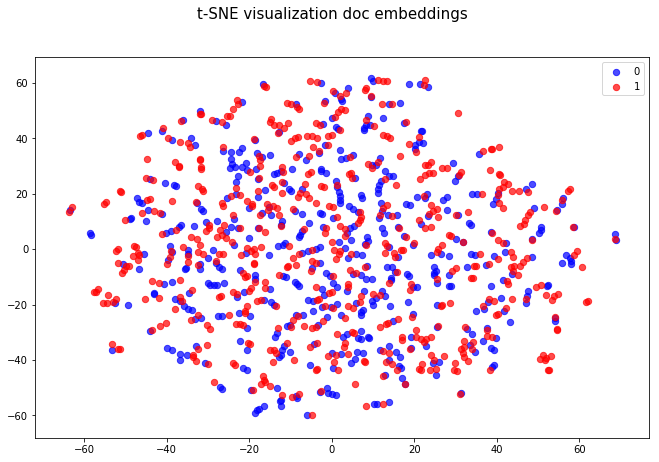

In [42]:
# = = = = = visualizing doc embeddings (before training) = = = = =

### fill the gap ###
### create a K.function 'get_doc_embedding()' that returns the inner representation of the model before the prediction layer ###
### this function should take as input the input of the model and return the output of the penultimate layer ###
### you can access the layers of the model with model.layers ###
### a specific layer can then be accessed via its index, e.g., model.layers[0] ###
### the indexes of the layers can be inferred by calling model.summary() ###
### the input and output of a given layer can be accessed via, e.g., model.layers[0].input and model.layers[0].output ###
### see: How can I obtain the output of an intermediate layer? here: https://keras.io/getting-started/faq/ ###

get_doc_embedding = K.function([model.layers[0].input, K.learning_phase()], [model.layers[9].output])

n_plot = 1000
labels_plt = y_test[:n_plot]
doc_embs = get_doc_embedding([np.array(x_test[:n_plot]),0])[0]
print(doc_embs.shape)

print('plotting embeddings of first',n_plot,'documents')
visualize_doc_embeddings(doc_embs,['blue','red'],labels_plt,'before')

In [43]:
# = = = = = training = = = = =

### note: if you don't have a GPU, you may use a subset of x_train and y_train to speed up training ###

my_patience = 2
early_stopping = EarlyStopping(monitor='val_acc', # go through epochs as long as accuracy on validation set increases
                               patience=my_patience,
                               mode='max')
model.fit(np.array(x_train),
          y_train,
          batch_size = batch_size,
          epochs = nb_epochs,
          validation_data = (np.array(x_test), y_test),
          callbacks = [early_stopping])

Train on 25000 samples, validate on 25000 samples
Epoch 1/6
25000/25000 [==============================] - 6s 243us/step - loss: 0.6367 - accuracy: 0.6306 - val_loss: 0.5243 - val_accuracy: 0.7414
Epoch 2/6
  896/25000 [>.............................] - ETA: 4s - loss: 0.4994 - accuracy: 0.7902

/home/infres/fomrane/.local/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


25000/25000 [==============================] - 6s 224us/step - loss: 0.4748 - accuracy: 0.7778 - val_loss: 0.4828 - val_accuracy: 0.7616
Epoch 3/6
25000/25000 [==============================] - 5s 212us/step - loss: 0.3744 - accuracy: 0.8398 - val_loss: 0.5008 - val_accuracy: 0.7591
Epoch 4/6
25000/25000 [==============================] - 6s 241us/step - loss: 0.2974 - accuracy: 0.8783 - val_loss: 0.5528 - val_accuracy: 0.7510
Epoch 5/6
25000/25000 [==============================] - 6s 235us/step - loss: 0.2339 - accuracy: 0.9097 - val_loss: 0.6211 - val_accuracy: 0.7447
Epoch 6/6
25000/25000 [==============================] - 8s 319us/step - loss: 0.1873 - accuracy: 0.9294 - val_loss: 0.6928 - val_accuracy: 0.7353


plotting embeddings of first  1000 documents after training


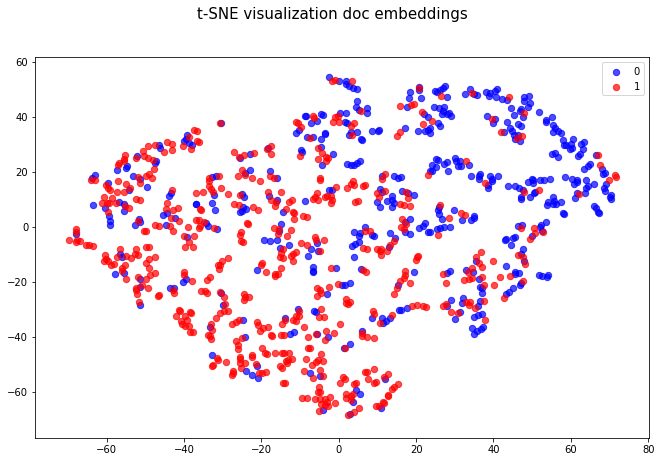

In [44]:
# = = = = = visualizing doc embeddings (after training) = = = = =

### fill the gaps ###
### perform the same steps as before training and observe the changes ###
doc_embs = get_doc_embedding([np.array(x_test[:n_plot]),0])[0]
print('plotting embeddings of first ',n_plot,'documents after training')
visualize_doc_embeddings(doc_embs,['blue','red'],labels_plt,'after')

In [25]:
# = = = = = predictive text regions for the first branch = = = = =

### fill the gaps ###
### define a K.function 'get_region_embedding' that returns the feature maps of the first branch ###
get_region_embedding = K.function([model.layers[0].input], [model.layers[3].output])

my_review_text = 'Oh , god , this was such a disappointment ! Worst movie ever . Not worth the 15 bucks .'
tokens = my_review_text.lower().split()
my_review = [word_to_index[elt] for elt in tokens]

# extract regions (sliding window over text)
regions = []
regions.append(' '.join(tokens[:filter_sizes[0]]))
for i in range(filter_sizes[0], len(tokens)):
    regions.append(' '.join(tokens[(i-filter_sizes[0]+1):(i+1)]))

my_review = np.array([my_review])
print(my_review.shape)

reg_emb = get_region_embedding([my_review,0])[0][0,:,:]
print(reg_emb.shape)

(1, 20)
(18, 50)


In [26]:
### fill the gap ###
### compute the norms of the region embeddings ###
### you may use np.linalg.norm() https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html ###
norms = np.linalg.norm(reg_emb, axis = 1)

print([list(zip(regions,norms))[idx] for idx in np.argsort(-norms).tolist()])

[('disappointment ! worst', 2.126277), ('! worst movie', 1.2551994), ('worst movie ever', 1.1675892), ('such a disappointment', 1.0126661), ('a disappointment !', 0.7177754), ('oh , god', 0.45821443), ('was such a', 0.15804864), ('15 bucks .', 0.14950283), ('the 15 bucks', 0.1281628), ('movie ever .', 0.123479046), ('this was such', 0.1203585), ('god , this', 0.11124229), ('ever . not', 0.10496481), ('. not worth', 0.10411305), (', god ,', 0.07589368), ('worth the 15', 0.07449075), (', this was', 0.06826035), ('not worth the', 0.06648315)]


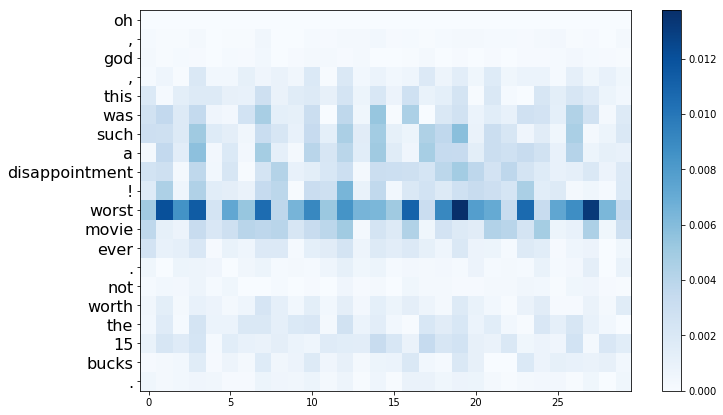

In [27]:
# = = = = = saliency map = = = = =
# read more here https://raghakot.github.io/keras-vis/visualizations/saliency/

input_tensors = [model.input, K.learning_phase()]

### fill the gap (extract the rows of the embedding matrix from the model) ###
saliency_input = model.layers[2].output

### fill the gap (get the probability distribution over classes from the model) ###
saliency_output = model.output

gradients = model.optimizer.get_gradients(saliency_output,saliency_input)

compute_gradients = K.function(inputs=input_tensors,outputs=gradients)

matrix = compute_gradients([my_review,0])[0][0,:,:]

### fill the gap (compute the magnitude of the partial derivatives) ###
### you may use np.absolute https://docs.scipy.org/doc/numpy/reference/generated/numpy.absolute.html ###
to_plot = np.absolute(matrix)

fig, ax = plt.subplots()
heatmap = ax.imshow(to_plot, cmap=plt.cm.Blues, interpolation='nearest',aspect='auto')
ax.set_yticks(np.arange(len(tokens)))
ax.set_yticklabels(tokens)
ax.tick_params(axis='y', which='major', labelsize=32*10/len(tokens))
fig.colorbar(heatmap)
fig.set_size_inches(11,7)
fig.savefig('saliency_map.pdf',bbox_inches='tight')
fig.show()
